## Table of Contents:
* 00\. [PhaseRetrieval](#phaseretrieval)
    * 00.1\. [Source code](#source-code)
    * 00.3\. [Requirements](#requirements)
    * 00.4\. [License](#license)
* 0\. [Remarks](#remarks) 
* 1\. [Image processing for phase retrieval](#image-processing-for-phase-retrieval) 
    * 1.1\. [Loading data](#loading-data)
        * 1.1.1\. [Object-domain images](#object-domain-images)
        * 1.1.2\. [Fourier-domain images](#fourier-domain-images)
    * 1.2\. [Processing in the object domain](#processing-in-the-object-domain)
        * 1.2.1\. [Background subtraction](#background-subtraction)
        * 1.2.2\. [Centering using watershed algorithm](#centering-using-watershed-algorithm)
        * 1.2.3\. [Resampling](#resampling)        
    * 1.3\. [Processing in the Fourier domain](#processing-in-the-fourier-domain)
        * 1.3.1\. [Zero-padding and centering](#zero-padding-and-centering)
        * 1.3.2\. [Subtraction of background](#subtraction-of-background)
        * 1.3.3\. [Renormalisation (Parseval's theorem)](#renormalisation)
    * 1.4\. [Saving processed images](#saving-processed-images)
* 2\. [Phase retrieval from two intensity measurements](#phase-retrieval-from-two-intensity-measurements)
    * 2.1\. [Gerchberg-Saxton algorithm](#gerchberg-saxton-algorithm)
    * 2.2\. [Gerchberg-Saxton algorithm with extrapolation](#gerchberg-saxton-algorithm-with-extrapolation)
* 3\. [Phase retrieval from the modulus of Fourier transform data](#phase-retrieval-from-the-modulus-of-Fourier-transform-data) 
* 4\. [References](#references) 

In [1]:
#remove_cell
import sys
import glob,os
from matplotlib import pyplot as plt
import numpy as np


datapath = '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data'
sourcepath = '/Users/Pavel/Documents/repos/PhaseRetrieval/'

sys.path.insert(0,sourcepath)
sys.path.insert(0,datapath)



#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

# PhaseRetrieval <a class="anchor" id="phaseretrieval"></a>

Author: Dr. Pavel Kliuiev

PhaseRetrieval is a 'work-in-progress' Python-based framework for solution of the phase problem. 

The phase retrieval problem is a mathematical problem of recovering an unknown object distribution (an unkwown function) from the known modulus of its Fourier transform. Phase retrieval algorithms ([Gerchberg-Saxton-1972](#Gechrberg-Saxton-1972)) make use of available information (such as real- or complex-valuedness of the object or its low-resolution optical image). The problem is widely encountered in imaging and signal processing and its applications range from adaptive optics for large space telescopes and 3D microscopic imaging of cells to imaging through turbulent atmosphere and visualisation of the valence orbitals of organic molecules. 

Prior to the application of phase retrieval algorithms, the data must be pre-processed. Section "Image processing for phase retrieval" lists typical steps needed to do such a pre-processing.

Section "Phase retrieval" (work in progress) provides a detailed description of the steps for the recovery of the object distributions either when only Fourier modulus is available or in case of availability of both the Fourier- and the object-domain data.

## Source code  <a class="anchor" id="source-code"></a>

The source code is located under https://github.com/pkliui/PhaseRetrieval

## Requirements  <a class="anchor" id="requirements"></a>

The software was tested using the following versions of the packages:

* ddt 1.3.1
* numpy 1.15.4    
* python 3.6.8
* pandas 0.24.2
* scipy 1.1.0
* scikit-image 0.16.2


## License  <a class="anchor" id="license"></a>

The source code is released under GNU General Public License v3.0

# Remarks about terms used <a class="anchor" id="remarks"></a>

In this manual, we explicitly distinguish between **"distribution" and "image"**. 

**Object distribution** refers to the non-zero-valued discrete representation of the physical distribution of an object limited to the object's physical boundaries. **Object image**, on the contrary, refers to discrete representation of the physical distribution of an object as captured by an imaging system. That is an image of an object contains not only the distribution of the object itself, but also the surrounding areas. In phase retrieval, one of the requirements for the solution of the phase problem is tht the object is surrounded by known transmission function (in *object image* all pixels around the *object distribution* are zero-valued, for example).

Similar considerations apply to **Fourier distribution** and **Fourier image**. We refer to the non-zero-valued discrete representation of the diffraction pattern of the object distribution, whose physical extent is limited by the numerical aperture or the detector area, as **Fourier distribution**.  **Fourier image** is then a Fourier distribution padded with zeros.

# Image processing for phase retrieval <a class="anchor" id="image-processing-for-phase-retrieval"></a>

The scheme below show typical image processing steps need to be done priot to application of phase retrieval algorithms.

![](improc_scheme.png)

## Loading data <a class="anchor" id="loading-data"></a>

### Object-domain images <a class="anchor" id="object-domain-images"></a>

Prior to the application of phase retrieval algorithms, input images must be pre-processed. From phase retrieval perspective, we consider the simplest case when both object- and Fourier-domain images are available to the user. The user is interested in recovering the phase information in the object domain. In this case, image pre-processing can be done with the classes ```RSpaceImage``` and ```KSpaceImage``` for object- and Fourier-domain images, respectively. 

> We start with the class ```RSpaceImage``` for  object-domain images which is initialised as follows.

In [2]:
from PhaseRetrieval.classes.rspaceimage import RSpaceImage
print(RSpaceImage.__init__.__doc__)


        Initializes the object-domain image class

        ---
        Parameters
        ---
        filename: str, optional
            Path used to load the image.
            If None, an empty class is created.
            If `image` argument is provided, the image will be initialized from the `image` argument.
            Default is None.
        delimiter: str, optional
            Delimiter used in the csv file (need to be specified if data are loaded from a csv file).
            If None, an empty class is created.
            Default is None.
        image : ndarray, optional
            2D array to initialize the image.
            If None, an empty class is created.
            Default is None.
        image_apodization_filter: ndarray, optional
            2D array to initialize the thresholded version of the image (i.e. image apodization filter).
            If None, an empty class is created.
            Default is None.
        


#### Read data <a class="anchor" id="read-data"></a>

The image is loaded by specifying keyword arguments ```filename```, which is the full path to an image to be loaded, and ```delimiter```, which, in case of images loaded from csv files, is a delimiter. In our case, we specified the datapath in the first cell and joined it with the filename.

There is also an option to read images from tif files. In this case, no delimiter needs to be specified. Only the full path to the file.

The loaded image can be plotted using ```plot_image``` method of ```RSpaceImage```class. To zoom in to the image, set the keyword argument ```zoom``` to any float > 1. The input images are typically not centred in the computational domain.

Object domain: Input image was read


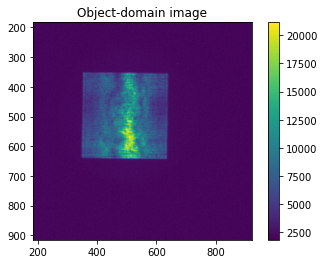

In [39]:
rs = RSpaceImage(filename=os.path.join(datapath,'rs35.csv'),
                 delimiter='\t')
rs.plot_image(zoom=1.5)

#### Rotation and flipping <a class="anchor" id="rotation-and-flipping"></a>

Sometimes, in the data acquisition process, mutual orientation of the object- and Fourier-domain images can be changed (i.e. horizontal and vertical axes in object-domain images can be either flipped or rotated with respect to those in Fourier-domain images). 

The data thus must be rotated counter-clockwise and/or flipped upside-down.

Rotation is done by ```rotate_image```method, ```times_rot=1```to rotate only once and ```estimate_only```is set to ```True```to only estimate how the image will look like if rotated and to ```False```to perform the rotation. The method roates the images counter-clockwise by default. To change the direction of the rotation, either set the keyword argument  ```axes```to ```(1,0)``` or just set the number of rotations to ```times_rot=3```.



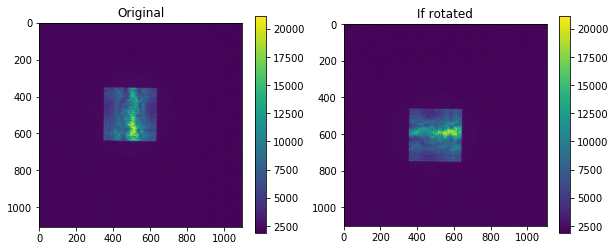

In [40]:
rs.rotate_image(times_rot=1, 
                estimate_only=True)

Object-domain: Input image was rotated


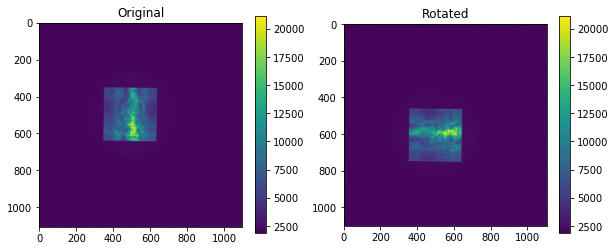

In [41]:
rs.rotate_image(times_rot=1, 
                estimate_only=False,
                plot_progress = True)

The flipping is done using ```flip_image```method. The method flips the image upside-down by default. To flip left-right, set the keyword argument ```axis```to ```0```. Set ```estimate_only```to ```True```to only estimate how the image will look like if flipped and to ```False```to perform the flipping.

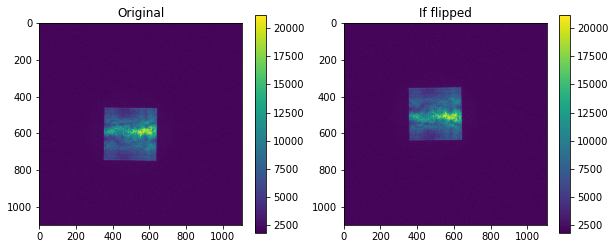

In [42]:
rs.flip_image(estimate_only=True)

Object-domain: Image was flipped


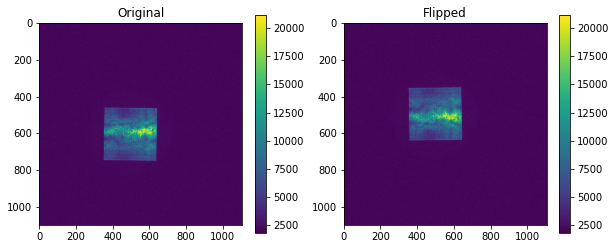

In [43]:
rs.flip_image(estimate_only=False, plot_progress = True)

### Fourier-domain images <a class="anchor" id="fourier-domain-images"></a>

The class for Fourier-domain images ```RSpaceImage``` is initialised equivalently.

In [44]:
from PhaseRetrieval.classes.kspaceimage import KSpaceImage
print(KSpaceImage.__init__.__doc__)


        Initializes Fourier-domain image class

        ---
        Parameters
        ---
        filename: str, optional
            Path used to load the image.
            If None, an empty class is created.
            If `image` argument is provided, the image will be initialized from the `image` argument.
            Default is None.
        delimiter: str, optional
            Delimiter used in the csv file (need to be specified if data are loaded from a csv file).
            If None, an empty class is created.
            Default is None.
        image : ndarray, optional
            2D array to initialize the image.
            If None, an empty class is created.
            Default is None.
        renorm_factor : float
            Renormalisation factor to fulfill Parseval's theorem
            If None, an empty class is created.
            Default is None.
        


#### Read data <a class="anchor" id="read-data"></a>

The data is read by specifying the ```filename``` keyword argument. To plot and zoom in to the Fourier-domain image, set the keyword argument ```zoom``` in ```plot_image```method of ```KSpaceImage```class to a number > 1. One may also set ```log_scale = True``` to plot the image in logarithmic scale and ```log_scale = False```to plot it in linear scale.

Fourier domain: Input image was read


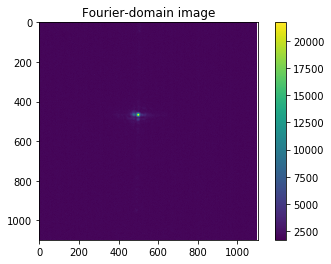

In [45]:
ks = KSpaceImage(filename=os.path.join(datapath,'ks35.csv'),
                 delimiter='\t')
ks.plot_image(zoom=1, 
              log_scale = False)

#### Rotation and flipping <a class="anchor" id="rotation-and-flipping"></a>

Rotation is done by ```rotate_image```method, ```times_rot=1```to rotate only once and ```estimate_only```is set to ```True```to only estimate how the image will look like if rotated and to ```False```to perform the rotation. The method roates the images counter-clockwise by default. To change the direction of the rotation, either set the keyword argument  ```axes```to ```(1,0)``` or just set the number of rotations to ```times_rot=3```.



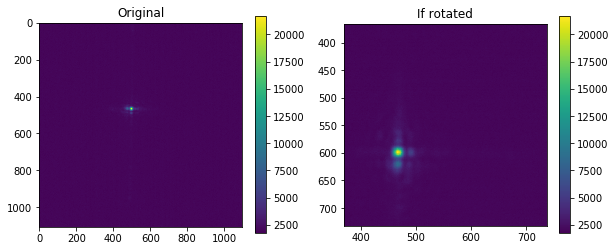

Fourier domain: This is how the image looks like if rotated.


In [46]:
ks.rotate_image(times_rot=1, 
                zoom=3, 
                estimate_only=True)

Fourier domain: Input image was rotated


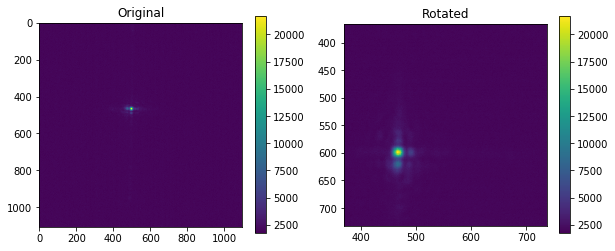

In [47]:
ks.rotate_image(times_rot=1, 
                zoom=3, 
                estimate_only=False,
                plot_progress = True)

The flipping is done using ```flip_image```method. The method flips the image upside-down by default. To flip left-right, set the keyword argument ```axis```to ```0```. Set ```estimate_only```to ```True```to only estimate how the image will look like if flipped and to ```False```to perform the flipping.

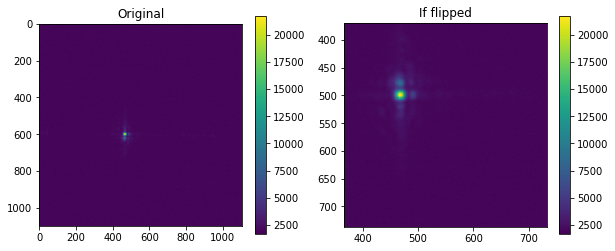

In [48]:
ks.flip_image(zoom=3, 
              estimate_only=True)

Fourier domain: Input image was flipped


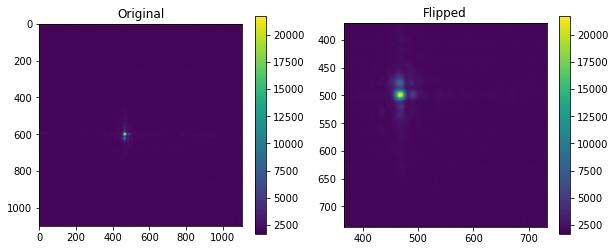

In [49]:
ks.flip_image(zoom=3, 
              estimate_only=False,
              plot_progress = True)

Similarly to the object-domain image, the Fourier data are de-centred too and hence must be placed in the middle of the computational domain.

## Processing in the object domain <a class="anchor" id="processing-in-the-object-domain"></a>

We start with the processing in the object domain.

### Background subtraction <a class="anchor" id="background-subtraction"></a>

The Fourier transform of white noise is noise. Thus, one may expect that by adding noise in Fourier domain we simply add noise to the corresponding object-domain distribution. In phase retrieval, however, the noise is recorded together with the intensity distribution in Fourier domain (diffraction pattern). And the corresponding object distribution is confined to a certain area surrounded by zeros, which is called object support. The application of such a constraint in the object domain does not allow noise in Fourier data to get translated into noise in object-domain data. As a result, noise in both domains must be subtracted as the quality and the resolution of the reconstruction highly depend on the presence of noise in the input images.

We simplify the substraction procedure by assuming that the noise distribution is quasi-constant throughout the whole image. The background can be subtracted using ```subtract_background```method of class ```RSpaceImage```.

Set ```estimate_only=True``` to estimate how the image will look like after the background subtraction. Plotting in logarithmic scale makes it easier to see whether the counts' value is high enough.

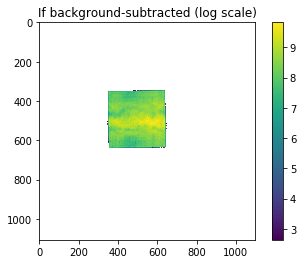

Object domain: This is how the image looks like if the background were subtracted.
Object domain: Background was set to  2610


In [50]:
rs.subtract_background(counts=2610, 
                       estimate_only=True, 
                       zoom=1.0,
                       log_scale=True)

When one is satisfied with the result, set ```estimate_onyl=False``` and the specified number of counts will be subtracted from the image.

Object domain: Plotted in log scale


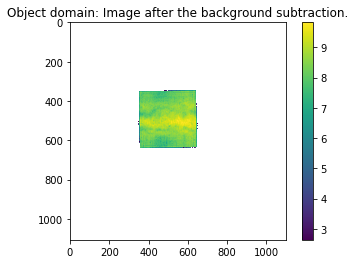

Object domain: Background of 2610 counts was subtracted.


In [51]:
rs.subtract_background(counts=2610, 
                       estimate_only=False, 
                       log_scale=True,
                       plot_progress = True)

### Centering using watershed algorithm<a class="anchor" id="centering-using-watershed-algorithm"></a>

The centering can be done using ```centre_image_watershed``` method of class ```RSpaceImage```. We use watershed algorithm to locate the boundaries of the square-shaped object distribution, compute its centre of mass and, finally, centre it in the computational domain. There is an option to pad the image with zeros to a number of pixels higher than the original one (to make the number of pixels in both dimensions equal, for example). Another reason for zero-padding is that according to the properties of the digital Fourier transform, higher linear number of pixels in Fourier domain leads to a higher number of pixels allocated per unit length in the object domain (but keeps the resolution unaltered). The method returns information about the linear size of the pixel in the object domain, which will be used later on in the processing. The object's boundaries may optionally be apodized with a gaussian filter.

Processing steps:

* Compute distance transform of the background-free image
* Use this image as an input to watershed algorithm
* Zero-pad to a desired number of pixels
* Find the centre of mass of the padded watershed image
* Centre it 

> Note that typically distance transform is computed for binary images. This is because distance transform is very sensitive to small changes in the object. For example, adding salt-and-pepper noise will significantly corrupt even a binary image. 
> Here we use scipy's ndi.distance_transform_edt function to compute Eucledian distance transform of the backgorund-free image. This function computes the Eucledian distance from non-zero pixels to the nearest zero pixels (upon background subtraction we set all negative pixel values to zero). Hence distance transform allows to roughly estimate the object's boundaries. 

In [52]:
print(rs.centre_image_watershed.__doc__)


        Centers the object-domain image using watershed algorithm (the existence of only a single blob is assumed).
        Finds its physical linear pixel size.
        Completes zero-padding of the original image to a specified linear number of pixels
        Applies an apodization filter to smooth boundaries of the object distribution (optional)

        ---
        Parameters
        ---
        linear_object_size: float, optional
            Physical linear size of the (non-zero-valued) input object distribution, in m.
            Default is 100 micrometer.
        npixels_pad: int, optional
            Linear number of pixels in the zero-padded object-domain image.
            Default is 2000.
        apodization: bool, optional
            If True, the boundaries of the object distribution will be smoothed using Gaussian filter
            with standard deviation = 1 and truncation of the filter's boundaries to 2
            (fixed at the moment, but may/should be changed in th

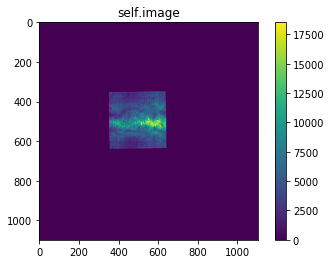

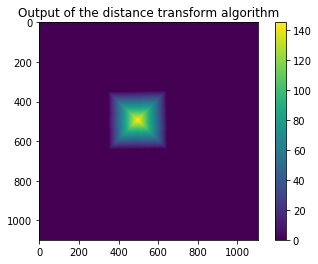

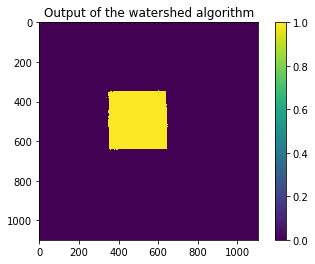

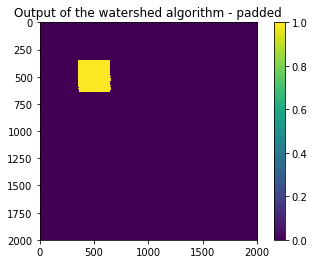

Object domain: Input and watershed images were padded to  2000 X 2000 pixels.


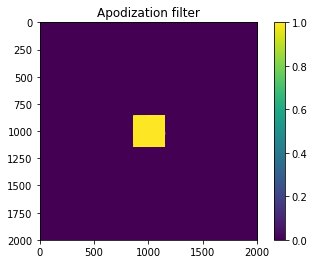

Object domain: Image centred. Apodization filter was applied. Linear pixel size is  0.0 nm


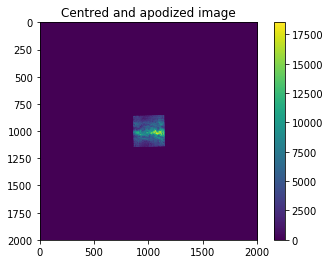

In [53]:
rs.centre_image_watershed(linear_object_size=100e-6,  
                          npixels_pad=2000, 
                          apodization=True,
                          plot_progress = True)

### Re-sampling <a class="anchor" id="resampling"></a>

The pixel sizes in the object domain, $\Delta r$ [m], and Fourier domain, $\Delta k$ [rad/m], are connected as 

$\Delta r \Delta k = \frac{2\pi}{N}$,                      (1)

where $N$ is the linear pixel number.  If one aims at using both object- and Fourier-domain images in phase retrieval algorithms, equation (1) must be fulfilled. Typically, this is not the case for raw data and either of images must be resampled to ensure correct application of the discrete Fourier transform. 

Let's assume the pixel sizes of unprocessed object- and Fourier-domain images are $\Delta r_{oo}$ and $\Delta k_{FF}$, respectively. These pixel sizes are set by experimental conditions, such as optical magnification, and hence are fixed. Object distribution is confined to $N_{oo}\times N_{oo}$ pixels area and is surrounded by a zero-padded region. The total area of the object-domain image is thus sampled with $N_o\times N_o$ pixels ($N_o > N_{oo}$) which is set either by imaging conditions or by user choosing an appropriate width of the zero-padded region. 

In Fourier domain, the size of the non-zero-valued area is set by the field of view of the imaging system to $N_{FF} \times N_{FF}$ pixels. 

If we set $N_{o}$ such that $N_{o}=N_{FF}$, then, according to equation (1), the effective size of the pixel in Fourier domain should be $\Delta k_\textrm{eff} = \frac{2\pi}{N_{o}\Delta r_{oo}}$. Hovewer, typically, $\Delta k_\textrm{eff} \neq \Delta k_{FF}$, as both $\Delta r_{oo}$ and $\Delta k_{FF}$ are set by experimental conditions and cannot be easily changed. 

Similarly, if $N_{o}=N_{FF}$, the effective size of the pixel in the object domain is $\Delta r_\textrm{eff} = \frac{2\pi}{N_{o}\Delta k_{FF}}$ and, typically, $\Delta r_\textrm{eff} \neq \Delta r_{oo}$. 

The data must be thereby re-sampled in either domain to fulfill equation (1). Here, $D = \left[\frac{\Delta r_\textrm{eff}}{\Delta r_\textrm{oo}}\right]>1$, which we call the downsampling ratio and $[]$ denote rounding to the nearest integer, as not necessarily $\frac{\Delta r_\textrm{eff}}{\Delta r_\textrm{oo}} \in \mathrm{Z}$. 

Because, in our case, object-domain images have got less high-frequency features and thus should be less prone to re-sampling-induced errors, we re-sample object-domain images by  ```resize```method implemented in ```scikit-image``` with ```anti-aliasing``` argument set to ```True```.

After re-sampling, the object-domain image is zero-padded to a new linear number of pixels:

$N = \left[ \frac{2\pi}{D * \Delta r_{oo} * \Delta k_{FF}} \right]$      (2).

> In PhaseRetrieval package, resampling can be done with ```resample_image```method of class ```RSpaceImage```. 

In [54]:
print(rs.resample_image.__doc__)


        Resamples object-space image to equalise its pixel size to the one set by
        digital Fourier transform and the pixel size in the experimental Fourier-space image

        ---
        Parameters
        ---
        fieldofview: int, optional
            One half of field of view in Fourier-space, in degrees
            Default is ±17°, i.e. fieldofview = 17
        npixels_kspace: int, optional
            One half of linear number of non-zeros-valued pixels in experimental Fourier-space image to be used together with the real-space image
            (= corresponds to the linear number of pixels within the 1/2 of field of view)
            Default is 500
        pixelsize_dr0: int, optional
            Pixel size in experimental object-domain image, in m.
            If it is None, the value will be read from metadata (saved to metadata after centering and segmentation of the image).
            If the value in metadata is None, there will be an error message.
            

> From calibration data (not shown), the non-zero-valued linear number of pixels in the Fourier-domain image, $N_{FF}$, is ```npixels_kspace = 726```. This number corresponds to the optical field of view ```fieldofview = ±17°```. The pixel size in the object domain, $\Delta r_{oo}$, can be estimated from the watershed segmentation and is set to ```pixelsize_dr0 = 426``` pixels in the example below. From this information, the algorithm computes the size of the pixel in Fourier domain $\Delta k_{FF}$, the downsampling ratio $D$, re-samples the image and zero-pads it to a new linear number of pixels, $N$, as set by equation (2).

In [55]:
rs.resample_image(fieldofview = 17, 
                 npixels_kspace = 726/2,
                 pixelsize_dr0 = 426e-9,
                 lambd = 880e-9, 
                 estimate_only = True)

Object domain: Downsampling ratio = 1.0


2565

In [56]:
rs.resample_image(fieldofview = 17, 
                 npixels_kspace = 726/2,
                 pixelsize_dr0 = 426e-9,
                 lambd = 880e-9, 
                 estimate_only = False)

Object domain: Input image shape is  2000 X 2000
Object domain: Image was resampled and its current shape is (2000, 2000)
Object domain: Image was resampled with the downsampling ratio = 1.0 and zero-padded to npixels_final X npixels_final= 2564 X 2564 pixels


2564

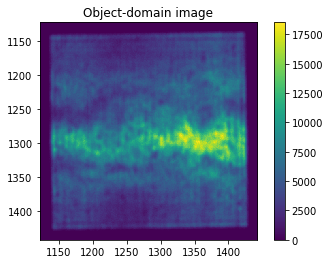

In [57]:
rs.plot_image(zoom=8)

## Processing in the Fourier domain <a class="anchor" id="processing-in-the-fourier-domain"></a>

### Zero-padding and centering <a class="anchor" id="zero-padding-and-centering"></a>

The image can be centred using ```centre_image```method of ```KSpaceImage```class. This method finds local maximal within a specified region of interest (ROI).



In [58]:
print(ks.centre_image.__doc__)


        Centers the Fourier-domain image whose centre is located at one of its local maxima
        Completes zero-padding of the original image to a specified linear number of pixels

        ---
        Parameters
        ---
        roi: tuple, optional
            Region of interest (ROI) used to search for local maxima.
            Default is (0,10,0,10).
        centre: tuple, optional
            Centre of the image.
            Default is (1,1), which must be changed by user once the centre of the image (one of the local maxima) is found.
        gaussian_filter : bool, optional
            Apply Gaussian filter to filter noise
            Default is False
        sigma : float, optional
            Standard deviation of a Gaussian filter
            Defailt is 1.0
        min_distance, int, optional
            Minimal distance between the local maxima
            Must be tuned by user to make the search most effective.
            Default is 10.
        threshold_abs: float,

The image can be centred using ```centre_image```method of ```KSpaceImage```class. This method finds local maximal within a specified region of interest (ROI).

* Set ```estimate_only = True```. This will allow tuning the parameters of the procedure and to find the local maximum which, in user's opinion, corresponds to the centre of the image. Setting ```estimate_only = Fals``` will use the coordinates specified in ```centre```argument and will irreversibly centre the image. 

* At this point, ```centre```argument can be arbitrary.

* Set the region of interest  (ROI) ```roi```argument. The first two numbers are the coordinates of the bottom left corner, the last two are of the top right corner of the ROI box.

* Set the other arguments.

* ```npixels_pad```must be set to linear number of pixels in the object-domain image after it was resampled.

* Run the cell and the procedure will find local maxima and will show their coordinates on the plot. If you think the right local maximum was found, copy its coordinates to ```centre```argument and set ```estimate_only=False```. 

* Run the cell. The procedure will centre the image and pad it to around with zeros to a linear number of pixels specified  in ```npixels_pad```.

* If the desired local maximum was not found, try changing ```min_distance```, ```threshold_abs``` and ```num_peaks```arguments.

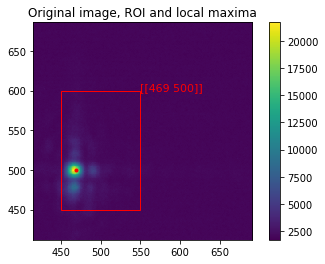

In [59]:
ks.centre_image(estimate_only = True, 
                centre = (469, 500), 
                roi=(450,450,550,600), 
                min_distance = 5, 
                threshold_abs = 5000, 
                num_peaks = 1,  
                zoom = 4, 
                npixels_pad = 2564,
                plot_progress = True)

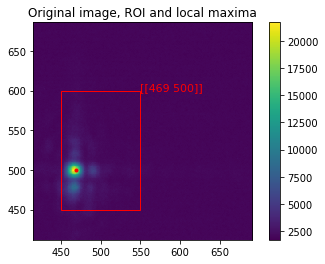

Fourier domain: Input image was padded to  2564 X 2564 pixels and centred.


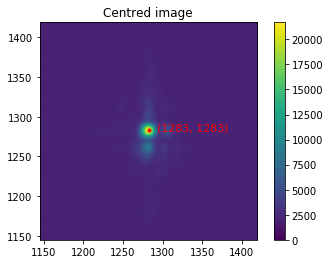

In [60]:
ks.centre_image(estimate_only = False, 
                centre = (469, 500), 
                roi=(450,450,550,600), 
                min_distance = 5, 
                threshold_abs = 5000, 
                num_peaks = 1,  
                zoom = 4, 
                npixels_pad = 2564,
                plot_progress = True)

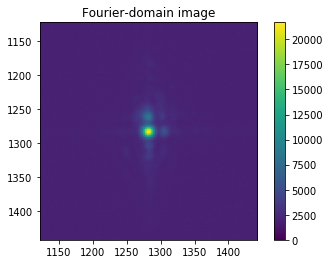

In [61]:
ks.plot_image(zoom=8)

> Optionally, the image can be centred manually by specifying the coordinates of its centre using ```centre_image_manually```method.

> ks.centre_image_manually(manual_centroid=(469, 500), npixels_final=2000)

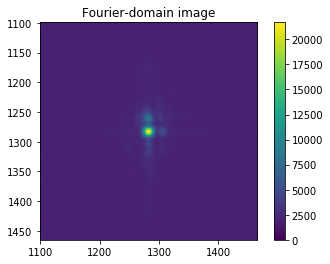

In [62]:
ks.plot_image(zoom=7)

### Subtraction of background <a class="anchor" id="subtraction-of-background"></a>

Similarly, we assume that the noise distribution is quasi-constant throughout the whole Fourier-domain image. The background is subtracted using ```subtract_background```method of class ```KSpaceImage```.

Set ```estimate_only=True``` to estimate how the image will look like after the background subtraction. Plotting in logarithmic scale makes it easier to see whether the counts' value is high enough.

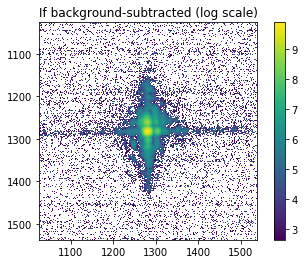

Fourier domain: This is how the image would look like if the background were subtracted.
Fourier domain: Background was set to  2050


In [63]:
ks.subtract_background(counts = 2050, 
                       estimate_only=True,
                       zoom = 5,
                       log_scale = True)

When one is satisfied with the result, set ```estimate_only=False``` and the specified number of counts will be subtracted from the image.

Fourier domain: Plotted in log scale


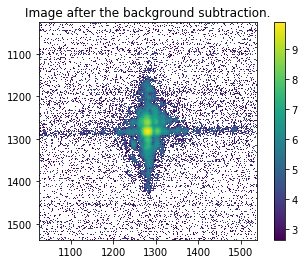

Fourier domain: Background of 2050 counts has been subtracted.


In [64]:
ks.subtract_background(counts = 2050, 
                       estimate_only=False,
                       zoom = 5,
                       log_scale = True,
                       plot_progress = True)

### Renormalisation (Parseval's theorem) <a class="anchor" id="renormalisation"></a>

Now when both images are correctly sampled and have equal linear number of pixels $N$, we must renormalise one of them to fulfill Parseval's theorem:

$\sum\limits_{i = 0}^{N-1}\sum\limits_{j=0}^{N-1} |x[i,j]|^2  = \frac{1}{N^2} \sum\limits_{m=0}^{N-1}\sum\limits_{n=0}^{N-1} |X[m,n]|^2 $, (3)


where $i,j$ refer to the object space coordinates and $m,n$ to the Fourier space coordinates. We renormalise the Fourier-domain image.

> Compute energy in the object domain

In [65]:
energy_rspace = sum(sum(rs.image))
print(energy_rspace)

451195734.1543496


> Renormalise in the Fourier domain.

In [66]:
ks.renormalise_image(energy_rspace)

Fourier domain: Energy =  2966204071121175.0
Energy in object's domain * total number of pixels:  2966204071121173.5
Fourier domain: Image was renormalised. Parseval's theorem is NOT fulfilled.


Equation (3) is now fulfilled.

## Saving processed images <a class="anchor" id="saving-processed-images"></a>

> Processed images are saved using ```save_as_tif``` method of ```RSpaceImage```and ```KSpaceImage``` classes. A user must enter a filename and specify a path to save the data. The data are saved as float32 data type.

In [67]:
ks.save_as_tif(pathtosave=datapath, outputfilename="ks_processed_amplitude.tif")


Fourier domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/ks_processed_amplitude.tif
Fourier domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/ks_processed_amplitude.csv


In [68]:
rs.save_as_tif(pathtosave=datapath, outputfilename="rs_processed_amplitude.tif")

Object domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/rs_processed_amplitude.tif
Object domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/rs_processed_amplitude.csv


The data are saved as float32 tif images. Its metadata are saved in csv files bearing the same names as the correspnding tif files.

# Phase retrieval from two intensity measurements <a class="anchor" id="phase-retrieval-from-two-intensity-measurements"></a>

We have both object and Fourier domain images available. We are interested in reconstructing object's phase distribution. This mathematical problem can be solved using Gerchberg-Saxton algorithm [[Gerchberg-Saxton-1972](#Gerchberg-Saxton-1972)]. 

Its schematic is shown below. The algorithm starts with a random phase distribution in Fourier domain. Computed amplitudes in both domains are replaced with the corresponding measured images and the phase distributions are kept the same. The algorithm iterates between both domains by computing discrete Fourier transform until it converges.

<img src = "gerchberg_saxton_scheme.pdf" style="width:1000px"/>

The images must be pre-prepocessed as described in the previous section. In particular, as shown in [Centering using watershed algorithm](#centering-using-watershed-algorithm) and [Resampling](#resampling) sections, users specify a linear number of pixels for original object-domain images to be zero-padded to. Object-domain images are then re-sampled to fulfill digital Fourier transform propertis set by equation (1) and, finally, zero-padded to a new linear number of pixels.  

For purposes outlined <font color=red>**later in the text** </font>, it is often required to test how different linear number of pixels impact final reconstructions. Last but not least, users might want to test different levels of noise to be subtracted from the images.

The following workflow demonstrates how these goals can be achieved using the methods of ```rspaceimage```, ```kspaceimage```and  ```phaseretrieval``` classes

## Oversampling requirements <a class="anchor" id="oversampling-requirements"></a>

Solution of the phase problem requires the fulfillment of the oversampling condition [[Miao-1998](#Miao-1998)]. The intensity of the light field scattered off the object provides the amplitude of the Fourier transform of the object distribution:

\begin{equation}
\left| F(m_1\Delta q, m_2\Delta q) \right| = \left| \sum\limits_{n_1=0}^{N-1}  \sum\limits_{n_2=0}^{N-1}  f(n_1 \Delta r, n_2 \Delta r) e^{-2\pi\mathbb{i}(m_1n_1 + m_2n_2)/N}\right|, (4)
\end{equation}

where $n_1, n_2 = 0,1,2,...,N-1$ are the sample numbers in the object domain and $m_1, m_2 = 0,1,2,...,N-1$ are the sample numbers in the Fourier domain. $f$ denotes complex-valued object distribution and $F$ is  its Fourier transform. $\Delta r$ and $\Delta q$ are the samples in object and Fourier domains, respectively, connected as $\Delta r \Delta q = \frac{1}{N}$. 

Where $N$ is a linear number of pixels. Fourier-domain distribution (non-zero-valued pixels within the field of view) is sampled with $N_{FF}\times N_{FF}$ pixels. If the diffraction pattern is not zero-padded, then $N=N_{FF}$ and $N > N_{FF}$ otherwise. Object-distribution then has the same linear number of pixels  (non-zero-valued pixels) is sampled with $N_{oo} \times N_{oo}$ pixels (object distributions are typically confined so that $N_{oo} < N$).

Phase retrieval is equivalent to the solution of the system of equations (4). And to solve this system of equations uniquely, the number of equations must exceed the number of unknowns.

#### Complex-valued object distribution, only Fourier amplitude is known

In case of a complex-valued object distribution when only the Fourier amplitude distribution is known, this gives $N_{FF}^2$ equations and $2N_{oo}^2$ unknowns (the factor 2 accounts for the real and imaginary parts of the object distribution). To solve the system of equations (4) uniquely, the number of known variables must exceed the number of unknown variables:


\begin{equation}
N_{FF}^2  > 2N_{oo}^2.
\end{equation}

[[Miao-1998](#Miao-1998)] defined the so-called oversampling ratio as the ratio between the total (non-zero-valued) pixel number and the number of pixels with unknown values:

\begin{equation}
\sigma = \frac{\text{Total pixel number}}{\text{Number of unknown pixels}} = \frac{N_{FF}^2}{N_{oo}^2}
\end{equation}

In case of a complex-valued object distribution, the so-called linear oversampling condition then reads as $\mathbb{O} = \sqrt{\sigma} > \sqrt{2}$.



#### Complex-valued object distribution, amplitudes in both Fourier and object domains are known

In case of a complex-valued object distribution when both Fourier and object amplitude distributions are known, the number of equations stays ulaltered and is equal to $N_{FF}^2$. The number of unknowns is reduced to $N_{oo}$. 

To solve the system of equations (4) uniqeuly, the number of known variables must exceed the number of unknown variables:

\begin{equation}
N_{FF}^2 > N_{oo}^2.
\end{equation}

In this case, the linear oversampling ratio becomes $\mathbb{O} = \sqrt{\sigma} > 1$.




## Algorithm 1: Gerchberg-Saxton algorithm <a class="anchor" id="gerchberg-saxton-algorithm"></a>

> Import necessary packages.

In [69]:
import sys,os
import shutil, glob

> Set ```datapath``` and ```sourcepath```.  Datapath contains object- and Fourier-domain data. Sourcepath contains the source code.

In [70]:
datapath = '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data'
sourcepath = '/Users/Pavel/Documents/repos/PhaseRetrieval/'

sys.path.insert(0,sourcepath)
sys.path.insert(0,datapath)

> Import ```phaseretrieval``` method of ```PhaseRetrieval```class and change the directory to the sourcepath (needed only in jupyter notebook, otherwise setting the paths suffice)

In [71]:
from PhaseRetrieval.classes.phaseretrieval import PhaseRetrieval
os.chdir(sourcepath)

> Initialise ```PhaseRetrieval```class and use previously stored processed images as inputs.

In [72]:
#initialise phase retrieval class
pr = PhaseRetrieval(filename_rspace=os.path.join(datapath,"rs_processed_amplitude.tif"), filename_kspace=os.path.join(datapath,"ks_processed_amplitude.tif"))

file type is tif
object-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/rs_processed_amplitude.tif

object-domain metadata were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/rs_processed_amplitude.csv

file type is tif
Fourier-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/ks_processed_amplitude.tif



> Prior to application of phase retrieval algorithms, it makes sense to check if the oversamping ratio is fulfilled. The linear oversampling ratio must exceed ***$\sqrt{1}$*** for 2D data ***in case when both amplitude- and Fourier-domain images are available***. This can be done using ```check_oversampling_ratio```method of ```PhaseRetrieval```class. Set the argument ```extrapolation```to ```False```. The method also prints the metadata of the object-domain image.

In [73]:
pr.check_oversampling(extrapolation = False)

Wavelength of light, m                                             8.8e-07
Field of view, deg                                                      17
Number of pixels within the field of view                              363
Linear size of the object, m                                        0.0001
Pixel size object domain, m                                       4.26e-07
Linear number of pixels in the zero-padded real-space image           2000
Image centred and padded?                                              yes
Apodization filter applied?                                            yes
Parseval's theorem fulfilled?                                          NaN
Background subtracted?                                                 yes
Pixel size Fourier domain, 1/nm                                5.75077e+12
Pixel size object domain from padded Fourier data, 1/nm            546.291
dtype: object
linear oversampling ratio =  10.925817883195393
linear oversampling condition is fulfi

 > The oversampling ratio exceeds $\sqrt{1}$ and the data thus can be used for phase retrieval. We use Gerchberg-Saxton algorithm, which is implemented in ```gerchberg_saxton```method of ```PhaseRetrieval```class. 
 
> The arguments ```gs_steps``` and ```plot_progress```set the number of iterations and allow to display the progress each ```plot_every_kth_iteration``` iteration, respectively. HEre, for illustration purposes, we set ```gs_steps=10```. In reality, from hundreds to thousands of iterations may be required.

> RMS error in Fourier domain decreases with each iteration.

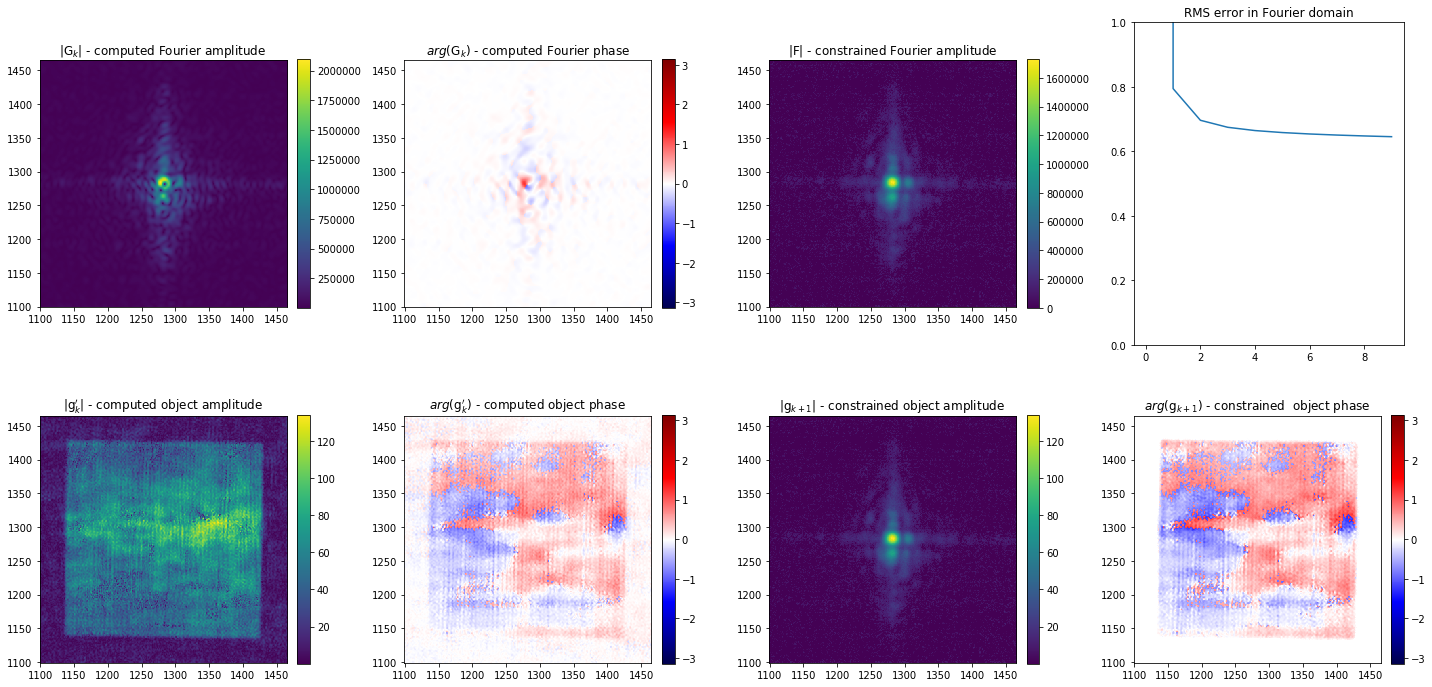

  completed


In [74]:
pr.gerchberg_saxton(gs_steps = 10, plot_progress = True, plot_every_kth_iteration = 2, zoom = 7)

> Upon completeion, save reconstructed images as csv files. **Because phase images may contain negative-valued pixels, saving in csv format preserves these negative pixel values by default.** Saving in tif with default parameters leads to the loss of negative values.

> Set  ```Fourier_amplitude```, ```Fourier_phase```, ```object_amplitude```, ```object_phase``` to ```True``` to save reconstructed Fourier amplitude, Fourier phase (top left corner in Fig. above), object amplitude and object phase images (bottom right corner in Fig. above), respectively.

In [75]:
pr.save_as_csv(filename="rs35ks35",
                pathtosave=datapath,
                Fourier_amplitude = True,
                Fourier_phase=True,
                object_amplitude=True,
                object_phase=True)

Fourier amplitude saved as  rs35ks35_Fourier_amplitude_164562000_20200819_094558.csv
Fourier phase saved as  rs35ks35_Fourier_phase_164562000_20200819_094558.csv
object amplitude saved as  rs35ks35_object_amplitude_164562000_20200819_094558.csv
object phase saved as  rs35ks35_object_phase_164562000_20200819_094558.csv


> Filenames will indicate the corresponding saved image type (i.e. _object_phase_), followed by reciprocal space error recorded at the last iteration of the retrieval algorithm, date (YYYYMMDD) and time (HHMMSS). The error is given in format (1X000), where X are for digits of the decimal part of the error.

## Algorithm 2: Gerchberg-Saxton algorithm with extrapolation <a class="anchor" id="gerchberg-saxton-algorithm-with-extrapolation"></a>

In the example above, the object distribution is physically confined to the area sampled with $N_{oo}\times N_{oo}$ pixels and spatial extent of its diffraction pattern is limited by the field of view of the imaging system. To fulfill the requirements of the discrete Fourier transform, equation (1), we modified them by re-sampling and zero-padding.

The spectrum of a size-limited object is infinite. Per definition, the discrete Fourier transform assumes the periodicity of the functions in both domains with the periods given by the linear number of pixels along each dimension. While zero-padding of the object-domain image can be justified due to the spatial confinement of the object, zero-padding in Fourier domain appears to be rather unnatural because the spectrum of the confined object distribution is infinitely extended and thus must not be truncated.

It is thereby makes sense to perform extrapolation of Fourier-domain data. Extrapolation of diffraction patterns in coherent diffraction imaging was suggested by [[Latychevskaia-2015](#Latychevskaia-2015)]. Here we follow the procedure described by Latychevskaia and co-workers.

We declare all zero-valued pixels in Fourier domain to be missing. The ratio between the number of missing pixels $N_\text{missing}$ and total pixel number $N_\text{total}$ is

\begin{equation}
f = \frac{N_\text{missing}}{N_\text{total}}.
\end{equation}

For zero-padded Fourier data, $N_\text{total} = N^2$. In object domain, there are $N_{oo}^2$ unknowns (object phases). Total number of measured (non-zero-valued) pixels is then $(1-f)N^2$. To solve the phase problem uniquely, the number of knowns must exceed the number of knowns.

\begin{equation}
(1-f)N^2  > N_{oo}^2,
\end{equation}

or, in terms of the linear oversampling ratio, $\mathbb{O}$, $f < 1 - \frac{1}{\mathbb{O}^2}$. 

**Example**

For $\mathbb{O} = 10.9$, we obtain f < 0.9916. Which means that even less than $1 \%$ of all Fourier domain pixels are enough to reconstruct both the object distribution and the missing pixel values in Fourier domain. In reality, however, the quality of the reconstruction heavily degrades when $f$ is high (i.e. higher than 0.6-0.7 [[Latychevskaia-2019](#Latychevskaia-2019)].)



### Step 1: Image processing and generation of object and Fourier domain images with different linear number of pixels and different levels of subtracted noise

In the following, we perform phase retrieval for different widths of the zero-padded regions (thus for different linear number of pixels) and various levels of subtracted noise in Fourier domain. Varying the linear number of pixels changes the number of missing pixels to be recovered in extrapolation and thus, together with different levels of subtracted noise, may have an impact on the quality of the reconstructions. 

We consider images having the same linear number of pixels and the same level of subtracted noise to be "of the same type".

> Import necessary packages

In [76]:
import sys,os
import shutil, glob

> Set ```datapath``` and ```sourcepath```.  Datapath contains object- and Fourier-domain data. Sourcepath contains the source code.

In [77]:
datapath = '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data'
sourcepath = '/Users/Pavel/Documents/repos/PhaseRetrieval/'
#datapath = '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35'



sys.path.insert(0,sourcepath)
sys.path.insert(0,datapath)

> Import ```phaseretrieval``` method of ```PhaseRetrieval```class and change the directory to the sourcepath (needed only in jupyter notebook, otherwise setting the paths suffice)

In [78]:
from PhaseRetrieval.classes.phaseretrieval import PhaseRetrieval
os.chdir(sourcepath)

> Using ```preprocessing_workflow``` function complete image processing for different linear number of pixels and noise. The function saves processed images under the specified datapath.

> The last three arguments ```npixels_pad_iter```, ```ks_noise_iter``` and ```rs_noise_iter``` are iterable and must be provided as lists of integers. The rest of the parameters are set equal to those used in section [Image processing for phase retrieval](#image-processing-for-phase-retrieval).

In [79]:
from PhaseRetrieval.scripts.scripts import preprocessing_script

preprocessing_script(datapath = datapath,
                       rs_filename = "rs35.csv",
                       ks_filename = "ks35.csv",
                       delimiter = '\t',
                       lambd=880e-9,
                       rs_pixelsize=340e-9,
                       rs_linear_object_size=100e-6,
                       ks_fieldofview = 17,
                       ks_npixels = 500,
                       ks_centre=(467, 500),
                       ks_gaussian_filter=True,
                       ks_sigma=1,
                       ks_roi=(400, 400, 550, 550),
                       ks_min_distance=5,
                       ks_threshold_abs=5000,
                       ks_num_peaks=5,
                       npixels_pad_iter = [2000],
                       ks_noise_iter = [1900, 2000, 2100],
                       rs_noise_iter = [2500],
                       suppress_print = False)

Processing images... Processing with linear number of pixels =  2000 ,Fourier-domain noise =  1900 ,Object-domain noise =  2500
Object domain: Input image was read
Object-domain: Input image was rotated
Object-domain: Image was flipped
Fourier domain: Input image was read
Fourier domain: Input image was rotated
Fourier domain: Input image was flipped
Object domain: Background of 2500 counts was subtracted.
Object domain: Input and watershed images were padded to  2000 X 2000 pixels.
Object domain: Image centred. Apodization filter was applied. Linear pixel size is  0.0 nm
Object domain: Input image shape is  2000 X 2000
Object domain: Image was resampled and its current shape is (1000, 1000)
Object domain: Image was resampled with the downsampling ratio = 2.0 and zero-padded to npixels_final X npixels_final= 2212 X 2212 pixels
Fourier domain: Input image was padded to  2212 X 2212 pixels and centred.
Fourier domain: Background of 1900 counts has been subtracted.
Fourier domain: Energy 

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:628: UserWarning: /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif is a low contrast image
  io.imsave(os.path.join(pathtosave, outputfilename), imagetosave.astype(np.float32))


Object domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif
Object domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.csv
Fourier domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_ks35_amplitude.tif
Fourier domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_ks35_amplitude.csv
Image processing completed.
Processing images... Processing with linear number of pixels =  2000 ,Fourier-domain noise =  2000 ,Object-domain noise =  2500
Object domain: Input image was read
Object-domain: Input image was rotated
Object-domain: Image was flipped
Fourier domain: Input image was read
Fourier domain: Input image was rotated
Fourier domain: Input image was fli

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:628: UserWarning: /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif is a low contrast image
  io.imsave(os.path.join(pathtosave, outputfilename), imagetosave.astype(np.float32))


Object domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif
Object domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.csv
Fourier domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_ks35_amplitude.tif
Fourier domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_ks35_amplitude.csv
Image processing completed.
Processing images... Processing with linear number of pixels =  2000 ,Fourier-domain noise =  2100 ,Object-domain noise =  2500
Object domain: Input image was read
Object-domain: Input image was rotated
Object-domain: Image was flipped
Fourier domain: Input image was read
Fourier domain: Input image was rotated
Fourier domain: Input image was fli

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:628: UserWarning: /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2100_rs35_amplitude.tif is a low contrast image
  io.imsave(os.path.join(pathtosave, outputfilename), imagetosave.astype(np.float32))


Fourier domain: Image was saved in tif file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2100_ks35_amplitude.tif
Fourier domain: Metadata was saved in csv file under  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2100_ks35_amplitude.csv
Image processing completed.


> Plot the result for the last data set

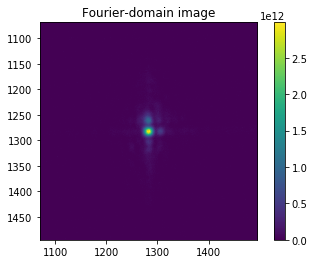

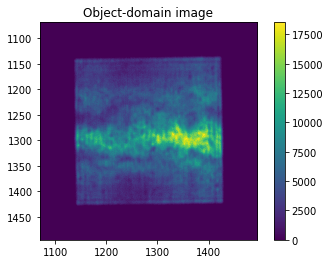

In [80]:
ks.plot_image(zoom=6)
rs.plot_image(zoom=6)

### Step 2: Apply Gerchberg-Saxton algorithm with extrapolation to the processed images

> Reconstruction by GS algorithm with extrapolation can be done by means of ```gerchberg_saxton_extraplation_script``` located under PhaseRetrieval/scripts/scripts of PhaseRetrieval repository. 

> * ```datapath``` argument sets the path to processed object- and Fourier-domain images.
*  ```rs_prefix```and ```ks_prefix``` arguments must be set to the original filenames of raw object- and Fourier-domain images (or parts of them) without extensions. This is required to be able to distinguish the processed files from other files present in the directory.
* ```files_extension``` must be chosen from the given set of extensions, i.e. either "*.tif" or "*.csv".
* The number of iterations is set by ```gs_steps```argument
* The number of reconstructions (the number of times GS algorithm is run with random initial phase distributions) is set by ```rec_number```
* ```filename``` argument defines an optional prefix to be appended at the beginning of the filenames of the reconstructed images.

In [81]:
from PhaseRetrieval.scripts.scripts import gerchberg_saxton_extrapolation_script

gerchberg_saxton_extrapolation_script(datapath = datapath,
                                   rs_prefix = "rs35",
                                   ks_prefix = "ks35",
                                   files_extension = "*.tif",
                                   gs_steps = 1,
                                   plot_progress = True,
                                   plot_every_kth_iteration = 10,
                                   zoom=6,
                                   Fourier_amplitude = True,
                                   Fourier_phase = True,
                                   object_amplitude = True,
                                   object_phase = True,
                                   filename = "rs35_ks35_",
                                   rec_number = 2,
                                   suppress_print = True)

file type is tif
object-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.tif

object-domain metadata were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise1900_rs35_amplitude.csv

file type is tif
Fourier-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/ks35_Ntot2000rsnoise2500ksnoise2100.tif

file type is tif
object-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif

object-domain metadata were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.csv

file type is tif
Fourier-domain data were read as  /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/ks35_Ntot1110rsnoise2500ksnoise1900.tif



ValueError: operands could not be broadcast together with shapes (2212,2212) (1107,1107) 

> For each type of the processed images (i.e. images having the same linear number of pixels and the level of subtracted noise), script ```gerchberg_saxton_extrapolation_script```generates a directory, in which it copies the corresponding object- and Fourier-domain images and saves reconstructed image distributions. The output file structure under ```datapath``` thus looks as follows:

* Amplitude, object domain, raw data (typically .tif)
* Amplitude, Fourier domain, raw data (typically .tif)


* Amplitude, object domain, image type 1 (saved as .tif)
* Amplitude, object domain, metadata of image type 1 (saved as .csv)
* Amplitude, Fourier domain, image type 1 (saved as .tif)
* Amplitude, Fourier domain, metadata of image type 1 (saved as .csv)


* Folder with copies images of type 1 and reconstructed images:

    * Amplitude, object domain, image type 1 (saved as .tif)
    * Amplitude, Fourier domain, image type 1 (saved as .tif)
    * Reconstructed phase, object domain, using images type 1, reconstruction 1 (saved as .csv)
    * Reconstructed phase, object domain, using images type 1, reconstruction 2 (saved as .csv)
    * ...
    * Reconstructed phase, object domain, using images type 2, reconstruction ```rec_number``` (saved as .csv)


* Amplitude, object domain, image type 2
* Amplitude, object domain, metadata of image type 2 (saved as .csv)
* Amplitude, Fourier domain, image type 2
* Amplitude, Fourier domain, metadata of image type 2 (saved as .csv)


* Folder with copies images of type 2 and reconstructed images:

    * Amplitude, object domain, image type 2 (saved as .tif)
    * Amplitude, Fourier domain, image type 2 (saved as .tif)
    * Reconstructed phase, object domain, using images type 2, reconstruction 1 (saved as .csv)
    * Reconstructed phase, object domain, using images type 2, reconstruction 2 (saved as .csv)
    * ...
    * Reconstructed phase, object domain, using images type 2, reconstruction ```rec_number``` (saved as .csv)

...

> Reconstructed images are saved with self-descriptive strings in their filenames, such as  ```_object_phase_```or ```_Fourier_amplitude_```.

### Step 3: Alignment of reconstructed phase images (Gerchberg-Saxton)

> Reconstructed object-domain phase images are in spatial registry (because object-domain amplitude image was used as input to GS algorithm). However, individual phase images have an arbitrary phase shift which must be leleved prior to averaging of the images. Phase alignment can be done by ```phase_alignment_gerchberg_saxton``` function located under ```PhaseRetrieval/modules/postprocessing.py```. For alignment of phase images located in multiple folders, one can use ```phase_alignment_gerchberg_saxton_script``` located under ```PhaseRetrieval/scripts/scripts.py```.

In [7]:
from PhaseRetrieval.scripts.scripts import phase_alignment_gerchberg_saxton_script
print(help(phase_alignment_gerchberg_saxton_script))

Help on function phase_alignment_gerchberg_saxton_script in module PhaseRetrieval.scripts.scripts:

phase_alignment_gerchberg_saxton_script(datapath=None, folder_prefix=None, amplitude_prefix=None, phase_prefix=None, delimiter='\t', num_files_to_align=None, ref_coordinates=None, symmetric_phase=True, plot_progress=True, plot_every_kth_iteration=1, zoom=1, suppress_print=False)
    Script for alignment of phase images yielded by Gechrberg-Saxton algorithm (here it is assumed that images to align are in csv file format).
    It is assumed that the corresponding amplitude is known and the phases are all in spatial registry.
    That is, no registration is needed.
    ---
    Parameters
    ---
    datapath : str
        Path to a directory with folders containing reconstructed phase images.
        Default is None.
    amplitude_prefix : str, optional
        Prefix in the filename containing amplitude distribution associated with the phase images to be aligned.
        Default is None
  

> In the following, ```phase_prefix``` argument is set to ```"_object_phase_"```, although one can also align Fourier-domain phase images by setting it to ```"_Fourier_phase"```.

In [9]:
phase_alignment_gerchberg_saxton_script(datapath = datapath,
                                 folder_prefix = "Ntot",
                                 amplitude_prefix = "rs35_", 
                                 phase_prefix = "_object_phase_",
                                 delimiter = '\t',
                                 num_files_to_align=3,
                                 ref_coordinates = None,
                                 symmetric_phase = True,
                                 plot_progress = True,
                                 plot_every_kth_iteration = 1,
                                 zoom = 10,
                                 suppress_print = True)

> Plot reconstructied images

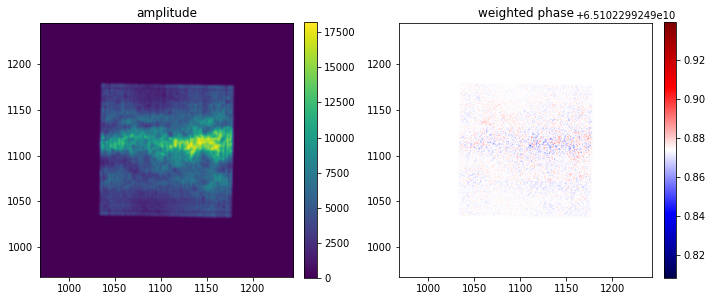

/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/Ntot2000rsnoise2500ksnoise2000_rs35_amplitude.tif


In [36]:
import os
from PhaseRetrieval.modules.postprocessing import plot_reconstruction

datapath = '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/'

amplitude_filenames =  [os.path.abspath(os.path.join(datapath, p)) for p in os.listdir(datapath) if p.endswith(('rs35_amplitude.tif'))]
phase_filenames =  [os.path.abspath(os.path.join(datapath, p)) for p in os.listdir(datapath) if p.endswith(('rs35_phase.csv'))]
print(amplitude_filenames)
print(phase_filenames)

for amplitude_filename, phase_filename in zip(amplitude_filenames, phase_filenames):
    plot_reconstruction(amplitude_filename = amplitude_filename, phase_filename = phase_filename, delimiter = '\t', zoom = 8)
    print(amplitude_filename)

['/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/Ntot1110rsnoise2500ksnoise1900_rs35_amplitude.tif', '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/Ntot1110rsnoise2500ksnoise2000_rs35_amplitude.tif', '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/Ntot1110rsnoise2500ksnoise2100_rs35_amplitude.tif', '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/Ntot1500rsnoise2500ksnoise1900_rs35_amplitude.tif', '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/Ntot1500rsnoise2500ksnoise2000_rs35_amplitude.tif', '/Users/Pavel/Documents/

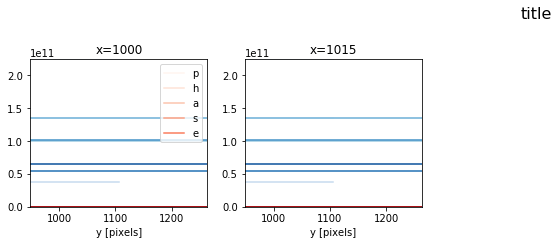

In [25]:
from PhaseRetrieval.modules.analysis import plot_sections_manyfiles

datapath = '/Users/Pavel/Documents/temp/on pc/phase_retrieval/BEC/20190124_S#16_20180122_IR792_080mM_800nm_original_AWESOME/20190124_rsp04_ksp16_050fs/35/'
import os

filenames =  [os.path.abspath(os.path.join(datapath, p)) for p in os.listdir(datapath) if p.endswith(('tif', 'csv'))]

plot_sections_manyfiles(filenames = filenames, 
                        figtitle='title', 
                        amplitude_kw = 'rs35_amplitude.tif', 
                        phase_kw = 'rs35_phase.csv', 
                        delimiter = '\t',
                        start=1000, 
                        step=15, 
                        stepsnum=2, 
                        slicedaxis='x', 
                        zoom=7)

## References <a class="anchor" id="references"></a>

[Gerchberg-Saxton-1972] R. W. Gerchberg and W. O. Saxton, "A practical algorithm for the determination of the phase from image and diffraction plane pictures,” Optik 35, 237 (1972) <a class="anchor" id="Gerchberg-Saxton-1972"></a>

[Latychevskaia-2015] T. Latychevskaia et al., Imaging outside the box: Resolution enhancement in X-ray coherent diffraction imaging by extrapolation of diffraction patterns
Appl. Phys. Lett. 107, 183102 (2015) <a class="anchor" id="Latychevskaia-2015"></a>

[Latychevskaia-2019] T. Latychevskaia, Reconstruction of missing information in diffraction patterns and holo452, 56-67 (2019) <a class="anchor" id="Latychevskaia-2019"></a>

[Miao-1998] J.W. Miao, D. Sayre, H.N. Chapman, Phase retrieval from the magnitude of the Fourier transforms of nonperiodic objects, J. Opt. Soc. Am. A, 15 (1998) 1662–1669. <a class="anchor" id="Miao-1998"></a>